# CIFAR-100 \~\~\~My Best Version\~\~\~
This is a notebook which classified CIFAR-100 by using google colaboratory.<br>
Test accuracy was 80.25 %.<br>
## Summary
* Accelerator: GPU
* Data Augmentation: Affine Transformation, Channel Shift, Cutmix
* Model: DenseNet - Transition - DenseNet - Transition - DenseNet - Transition - DenseNet - GAP - Dropout - Dense - Dropout - Dense
* Training: epochs<=300, batch_size=64, optimizer=Adam, Reduce Learning Rate
* Test Time Augmentation: epochs=20

Mount My Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

work_dir = "/content/drive/My Drive/Colab Notebooks/cifar100/"

Mounted at /content/drive


Import modules

In [ ]:
!pip install visualkeras
from visualkeras import layered_view

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import cv2

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict

import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.utils import plot_model
#from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.losses import categorical_crossentropy

print('tensorflow varsion:', tf.__version__)
print(tf.test.gpu_device_name())

tensorflow varsion: 2.4.1
/device:GPU:0


# Load and check data

Load data

In [ ]:
classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
            'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
            'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
            'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
            'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
            'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
            'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
            'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
            'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
            'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
            'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
            'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
            'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
            'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
            'worm']

len(classes)

100

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()

169009152/169001437 [==============================] - 2s 0us/step


Check data

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [ ]:
np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)

(0, 255, 0, 255)

In [ ]:
def plot_count(y, classes=None, title='y count'):
    plt.figure(figsize=(10,5))
    counter_y = [(key, value) for key, value in Counter(y).items()]
    counter_y.sort(key=lambda x: x[0])
    if classes is None:
        classes = [key for key, value in counter_y]
    values = [value for key, value in counter_y]
    plt.bar(classes, values)
    plt.xlabel('classes')
    plt.ylabel('count')
    plt.title(title)
    plt.show()


# show 10 images
def show_images(X, y_true=np.zeros(10), y_pred=None, classes=defaultdict(str)):
    plt.figure(figsize=(10,5))
    for i in range(min(10, X.shape[0], y_true.shape[0])):
        plt.subplot(2,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        # plot image
        try:
            plt.imshow(X[i], cmap=plt.cm.binary)
        except:
            plt.imshow(np.reshape(X[i],(X.shape[1],X.shape[2])), cmap=plt.cm.binary)

        # show y_true
        label = ''
        if len(y_true.shape) == 1:
            label += classes[y_true[i]]
        elif len(y_true.shape) == 2:
            label_rate = np.argsort(y_true[i])[::-1]
            if y_true[i][label_rate[0]] > 0.99:
                label = classes[label_rate[0]]
            else:
                label += classes[label_rate[0]] + ': ' + f'{y_true[i][label_rate[0]]:.2f}'
                label += '\n' + classes[label_rate[1]]+': ' + f'{y_true[i][label_rate[1]]:.2f}'
                
        # show y_pred
        if y_pred is None:
            plt.xlabel(label)
            continue

        plt.ylabel('Answer: ' + label)
        label = 'Prediction\n'
        if len(y_pred.shape) == 1:
            label += classes[y_pred[i]]
        elif len(y_pred.shape) == 2:
            label_rate = np.argsort(y_pred[i])[::-1]
            label += classes[label_rate[0]] + ': ' + f'{y_pred[i][label_rate[0]]:.2f}'
            if y_pred[i][label_rate[1]] > 0.01:
                label += '\n' + classes[label_rate[1]]+': ' + f'{y_pred[i][label_rate[1]]:.2f}'
        plt.xlabel(label)

    plt.show()

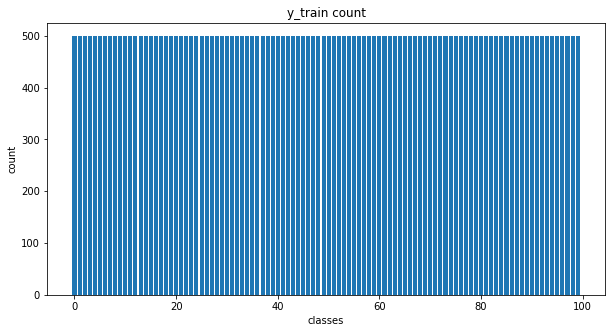

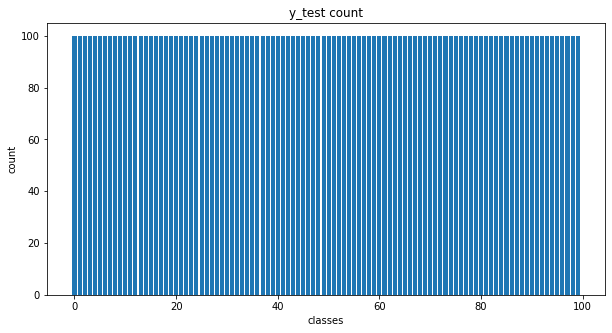

In [ ]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

plot_count(y_train, title='y_train count')
plot_count(y_test, title='y_test count')

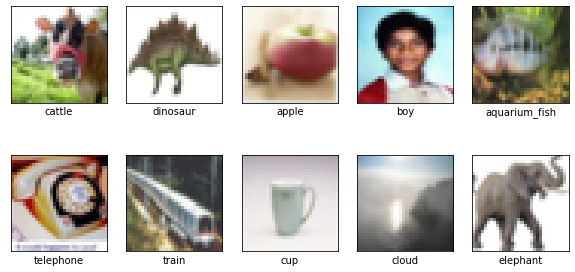

In [ ]:
show_images(X_train, y_train, classes=classes)

# Preprocess data

Normalize images

In [ ]:
X_train = X_train / 255
X_test = X_test / 255
np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)

(0.0, 1.0, 0.0, 1.0)

Change shapes

In [ ]:
y_train = keras.utils.to_categorical(y_train, len(classes))
y_test = keras.utils.to_categorical(y_test, len(classes))

train_test_split

In [ ]:
validation_seed = 0
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=validation_seed)

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 100) (10000, 100) (10000, 100)


# Augment data

In [ ]:
class MyImageDataGenerator:
    def __init__(self, function_on_a_image=None, function_on_two_batches=None):
        self.function_on_a_image = function_on_a_image
        self.function_on_two_batches = function_on_two_batches

    # You can use flow_with_labels when you train a model.
    def flow_with_labels(self, x, y, batch_size=32, shuffle=True):
        assert x.shape[0] == y.shape[0]
        steps = x.shape[0] // batch_size

        # get one batch for mix
        if self.function_on_two_batches is not None:
            prev_X_batch = x[-batch_size:].copy()
            if self.function_on_a_image is not None:
                prev_X_batch = np.array([
                                self.function_on_a_image(img) for img in prev_X_batch])
            prev_y_batch = y[-batch_size:]
        
        # flow
        while True:
            # shuffle
            if shuffle:
                perm = np.random.permutation(x.shape[0])
                x = x[perm]
                y = y[perm]
            
            # augment images
            for step in range(steps):
                X_batch = x[step*batch_size:(step+1)*batch_size].copy()
                y_batch = y[step*batch_size:(step+1)*batch_size].copy()
                if self.function_on_a_image is not None:
                    X_batch = np.array([self.function_on_a_image(img) for img in X_batch])
                if self.function_on_two_batches is not None:
                    X_batch, y_batch, prev_X_batch, prev_y_batch =\
                        self.function_on_two_batches(
                        prev_X_batch, prev_y_batch, X_batch, y_batch)
                yield X_batch, y_batch
    
    # You can use flow_without_labels in test time augmentation.
    def flow_without_labels(self, x, batch_size=100):
        assert x.shape[0] % batch_size == 0
        steps = x.shape[0] // batch_size
        while True:
            for step in range(steps):
                X_batch = x[step*batch_size:(step+1)*batch_size].copy()
                X_batch = np.array([self.function_on_a_image(img) for img in X_batch])
                yield X_batch
            yield None


# functions on a img
def color_shift(img, intensity=0.1):
    intensity = np.random.uniform(-intensity, intensity, (1,1,3))
    img = img + intensity
    img = np.clip(img, 0.0, 1.0)
    return img


def affine_transformation(img):
    ### arguments
    flags = cv2.INTER_LINEAR#cv2.INTER_NEAREST#
    borderMode = cv2.BORDER_REPLICATE#cv2.BORDER_CONSTANT#

    rotate_and_zoom_rate = 0.75#0.0#
    rotate_angle = (-20.0, 20.0)#(-0.0,0.0)#
    scale_range = (0.75, 1.25)#(1.0,1.0)#
    
    parallel_translation_rate = 0.75#0.0#
    width_shift_range = 0.1#0.2#
    height_shift_range = 0.1#0.2#

    horizontal_flip_rate = 0.5#0.0#
    vertical_flip_rate = 0.0#0.5#
    rotate_90_rate = 0.0#0.5#
    ###

    height = img.shape[0]
    width = img.shape[1]
    center = (height//2, width//2)

    # rotate and zoom
    if 0.0 < rotate_and_zoom_rate and np.random.rand() < rotate_and_zoom_rate:
        angle = np.random.uniform(rotate_angle[0], rotate_angle[1])
        scale = np.random.uniform(scale_range[0], scale_range[1])
        mat = cv2.getRotationMatrix2D(center, angle, scale)
        img = cv2.warpAffine(img, mat, (width, height),
                             flags=flags, borderMode=borderMode)
    
    # parallel translation
    if 0.0 < parallel_translation_rate and np.random.rand() < parallel_translation_rate:
        width_shift = int(width*width_shift_range)
        height_shift = int(height*height_shift_range)
        dx = np.random.randint(-width_shift, width_shift+1)
        dy = np.random.randint(-height_shift, height_shift+1)
        src_pts = np.array([[0,0], [0,height], [width, 0]], dtype=np.float32)
        dst_pts = np.array([[dx,dy], [dx,height+dy], [width+dx,dy]], dtype=np.float32)
        mat = cv2.getAffineTransform(src_pts, dst_pts)
        img = cv2.warpAffine(img, mat, (width, height),
                             flags=flags, borderMode=borderMode)
    
    # horizontal flip
    if 0.0 < horizontal_flip_rate and np.random.rand() < horizontal_flip_rate:
        img = cv2.flip(img, 1)

    # vertical flip
    if 0.0 < vertical_flip_rate and np.random.rand() < vertical_flip_rate:
        img = cv2.flip(img, 0)
    
    # rotate 90 degrees
    if 0.0 < rotate_90_rate and np.random.rand() < rotate_90_rate:
        if np.random.rand() < 0.5:
            img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        else:
            img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

    return img


# functions on two batches
def cutmix(X1, y1, X2, y2, alpha=0.5):
    h, w = X1.shape[1], X1.shape[2]
    beta = np.random.beta(alpha, alpha, X1.shape[0])
    beta = np.array([min(i, 1-i) for i in beta])
    sqrt_beta = np.sqrt(beta)

    for i in range(X1.shape[0]):
        mask_h = int(h * sqrt_beta[i])
        mask_w = int(w * sqrt_beta[i])

        top = np.random.randint(0, h-mask_h+1)
        left = np.random.randint(0, w-mask_w+1)

        X1[i][top:top+mask_h, left:left+mask_w, :] = X2[i][top:top+mask_h, left:left+mask_w, :]
    
    beta = np.expand_dims(beta, -1)
    y1 = (1-beta)*y1 + beta*y2
    return X1, y1, X2, y2

In [ ]:
def function_on_a_image(img):
    return color_shift(affine_transformation(img))

datagen = MyImageDataGenerator(function_on_a_image, cutmix)

Before augmentation


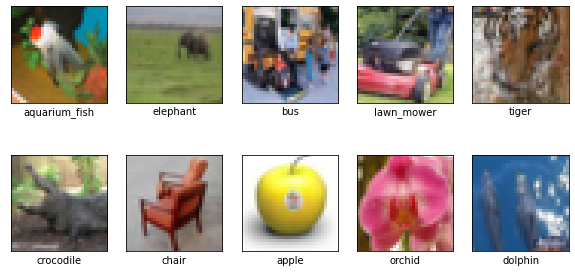

In [ ]:
print('Before augmentation')
show_images(X_train[10:20], y_train[10:20], classes=classes)

After augmentation


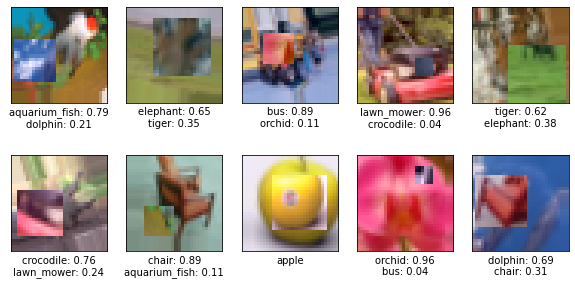

In [ ]:
print('After augmentation')
for X_batch, y_batch in datagen.flow_with_labels(
        X_train[10:20], y_train[10:20], batch_size=10):
    show_images(X_batch, y_batch, classes=classes)
    break

In [ ]:
%%timeit -r 5
def measure_time(datagen_flow, steps):
    cnt = 0
    for X_aug, y_aug in datagen_flow:
        cnt += 1
        if cnt == steps:
            break

measure_time(datagen.flow_with_labels(X_train, y_train, batch_size=64), 625)

1 loop, best of 5: 4.84 s per loop


# Create model

In [ ]:
# Dense Net
def create_model(input_shape, num_classes):
    filters = 64
    k = 32
    blocks = [6, 12, 24, 12]

    # Input Layers
    inputs = Input(input_shape)
    y = Conv2D(filters, (3,3), activation='relu', padding='same')(inputs)
    y = BatchNormalization()(y)

    for i in range(len(blocks)):
        # Transition Layers
        if i > 0:
            filters //= 2
            y = Conv2D(filters, (1,1), activation='relu')(y)
            y = BatchNormalization()(y)
            y = AveragePooling2D(pool_size=(2,2))(y)

        # DenseNet Layers
        for j in range(blocks[i]):
            x = Conv2D(128, (1,1), activation='relu')(y)
            x = BatchNormalization()(x)
            x = Conv2D(k, (3,3), activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            y = concatenate([x, y])
            filters += k

    # Output Layers
    x = GlobalAveragePooling2D()(y)
    x = Dropout(0.25)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
model = create_model(input_shape=X_train[0].shape, num_classes=len(classes))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 128)  8320        batch_normalization[0][0]        
______________________________________________________________________________________________

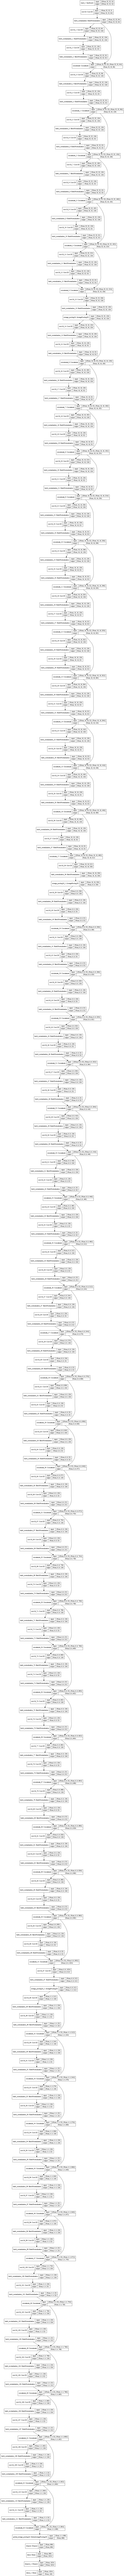

In [ ]:
plot_model(model, show_shapes=True, dpi=48)

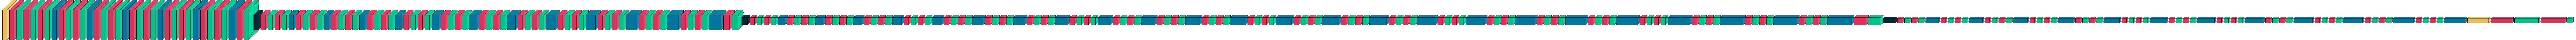

In [ ]:
layered_view(model)

# Train model

In [ ]:
weights_file_name = "best_weights(seed={}).hdf5".format(validation_seed)
model_file_name = "best_model(seed={}).h5".format(validation_seed)

In [ ]:
%%time

save_weights = ModelCheckpoint(filepath=os.path.join(work_dir, weights_file_name),
                                verbose=0, save_best_only=True, save_weights_only=True,
                                monitor='val_loss', mode='min')

early_stop = EarlyStopping(monitor='val_loss', mode='min',
                                patience=15, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min',
                                factor=0.8, patience=5, verbose=1)

model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

batch_size = 64
epochs = 300

history = model.fit(datagen.flow_with_labels(X_train, y_train, batch_size, shuffle=True),
                    validation_data=(X_valid, y_valid),
                    epochs=epochs,
                    steps_per_epoch=X_train.shape[0]//batch_size,
                    verbose=2,
                    callbacks=[save_weights, early_stop, reduce_lr])

model.save(os.path.join(work_dir, model_file_name))

Epoch 1/300
625/625 - 133s - loss: 4.3086 - accuracy: 0.0659 - val_loss: 3.7152 - val_accuracy: 0.1299
Epoch 2/300
625/625 - 116s - loss: 3.9230 - accuracy: 0.1226 - val_loss: 3.2721 - val_accuracy: 0.2056
Epoch 3/300
625/625 - 116s - loss: 3.6748 - accuracy: 0.1681 - val_loss: 2.9304 - val_accuracy: 0.2636
Epoch 4/300
625/625 - 116s - loss: 3.4695 - accuracy: 0.2113 - val_loss: 2.5077 - val_accuracy: 0.3403
Epoch 5/300
625/625 - 116s - loss: 3.3092 - accuracy: 0.2481 - val_loss: 2.4381 - val_accuracy: 0.3611
Epoch 6/300
625/625 - 116s - loss: 3.1790 - accuracy: 0.2804 - val_loss: 2.2911 - val_accuracy: 0.4029
Epoch 7/300
625/625 - 116s - loss: 3.0703 - accuracy: 0.3052 - val_loss: 1.9989 - val_accuracy: 0.4650
Epoch 8/300
625/625 - 116s - loss: 2.9740 - accuracy: 0.3288 - val_loss: 1.9292 - val_accuracy: 0.4794
Epoch 9/300
625/625 - 116s - loss: 2.8810 - accuracy: 0.3540 - val_loss: 1.8527 - val_accuracy: 0.5002
Epoch 10/300
625/625 - 116s - loss: 2.8261 - accuracy: 0.3693 - val_loss:

In [ ]:
def plot_history(history):
    # plot accuracy
    plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy'], marker='.', label='acc')
    plt.plot(history.history['val_accuracy'], marker='.', label='val_acc')
    plt.title('model accuracy')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.show()

    # plot loss
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], marker='.', label='loss')
    plt.plot(history.history['val_loss'], marker='.', label='val_loss')
    plt.title('model loss')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()

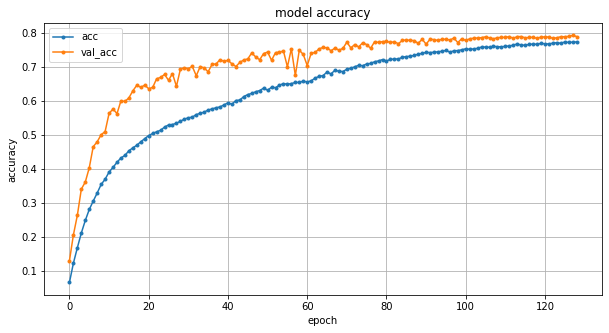

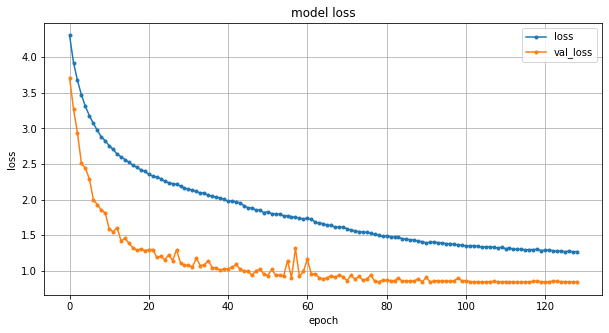

In [ ]:
plot_history(history)

# Augment validation data

In [ ]:
model.load_weights(os.path.join(work_dir, weights_file_name))
model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

In [ ]:
def test_time_augmentation(model, datagen_flow, steps, epochs=10):
    y_pred = model.predict(datagen_flow, steps=steps)
    for _ in range(epochs-1):
        y_pred += model.predict(datagen_flow, steps=steps)
    return y_pred / epochs


def calculate_loss_and_acc(y_test, y_pred):
    loss = np.average(categorical_crossentropy(y_test, y_pred))
    if len(y_test.shape) == 2:
        y_test = np.argmax(y_test, axis=1)
    if len(y_pred.shape) == 2:
        y_pred = np.argmax(y_pred, axis=1)
    acc = np.average(np.equal(y_test, y_pred))
    print('loss:', loss, 'acc:', acc)


def confusion_classes(y_test, y_pred, classes):
    if len(y_test.shape) == 2:
        y_test = np.argmax(y_test, axis=1)
    if len(y_pred.shape) == 2:
        y_pred = np.argmax(y_pred, axis=1)

    cmx = confusion_matrix(y_test, y_pred)
    cmx = np.ravel(cmx)
    cmx_idx = np.argsort(cmx)[::-1]
    table = []
    for i in range(len(classes)+10):
        pred = cmx_idx[i] // len(classes)
        ans = cmx_idx[i] % len(classes)
        if pred != ans:
            table.append([classes[pred], classes[ans], cmx[cmx_idx[i]]])
    return pd.DataFrame(table, columns=['answer','prediction','counts'])

In [ ]:
tta_datagen = datagen

Before augmentation


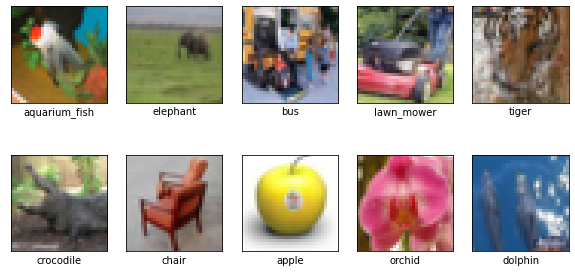

In [ ]:
print('Before augmentation')
show_images(X_train[10:20], y_train[10:20], classes=classes)

After augmentation


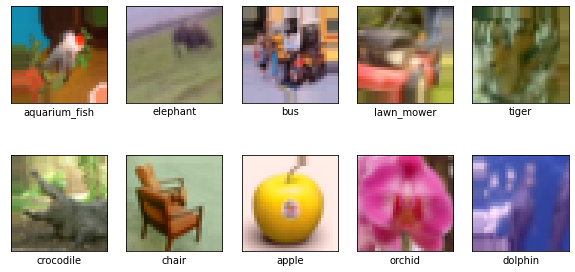

In [ ]:
print('After augmentation')
for X_batch in tta_datagen.flow_without_labels(X_train[10:20], batch_size=10):
    show_images(X_batch, y_train[10:20], classes=classes)
    break

In [ ]:
%%time

print('validation results')

print('without TTA')
loss, acc = model.evaluate(X_valid, y_valid, verbose=0)
print('loss:', loss, 'acc:', acc)

print('with TTA')
batch_size = 100
steps = X_valid.shape[0] // batch_size
assert batch_size * steps == X_valid.shape[0]

datagen_flow = tta_datagen.flow_without_labels(X_valid, batch_size=batch_size)
y_pred = test_time_augmentation(model, datagen_flow, steps, epochs=20)
calculate_loss_and_acc(y_valid, y_pred)
print()

validation results
without TTA
loss: 0.8343247175216675 acc: 0.7886999845504761
with TTA
loss: 0.7177348 acc: 0.7993

CPU times: user 1min 10s, sys: 6.09 s, total: 1min 17s
Wall time: 2min 32s


In [ ]:
confusion_classes(y_valid, y_pred, classes)

,answer,prediction,counts
0,man,woman,19
1,seal,otter,17
2,maple_tree,oak_tree,17
3,girl,woman,15
4,boy,girl,14
5,maple_tree,pine_tree,14
6,snake,worm,13
7,bowl,plate,12
8,apple,pear,12
9,couch,bed,11


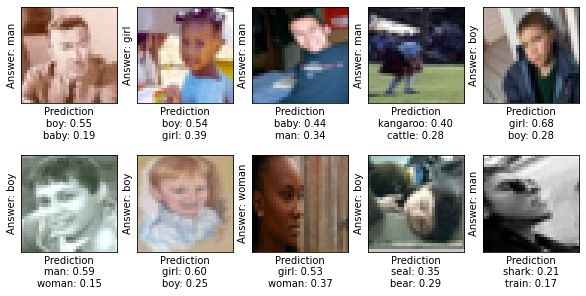

In [ ]:
# show mistaken human images
indexes = [classes.index('boy'), classes.index('girl'),
           classes.index('man'), classes.index('woman')]

miss_X = []
miss_y_valid = []
miss_y_pred = []
for i in range(y_valid.shape[0]):
    if np.argmax(y_valid[i]) in indexes and np.argmax(y_valid[i]) != np.argmax(y_pred[i]):
        miss_X.append(X_valid[i])
        miss_y_valid.append(y_valid[i])
        miss_y_pred.append(y_pred[i])
        if len(miss_X) == 10:
            break

miss_X = np.array(miss_X)
miss_y_valid = np.array(miss_y_valid)
miss_y_pred = np.array(miss_y_pred)
show_images(miss_X, miss_y_valid, miss_y_pred, classes)

# Calculate test loss and accuracy

In [ ]:
print('test results')

batch_size = 100
steps = X_test.shape[0] // batch_size
assert batch_size * steps == X_test.shape[0]

datagen_flow = tta_datagen.flow_without_labels(X_test, batch_size=batch_size)
y_pred = test_time_augmentation(model, datagen_flow, steps, epochs=20)
calculate_loss_and_acc(y_test, y_pred)

test results
loss: 0.70992607 acc: 0.8025
